In [ ]:
#

In [ ]:
import os
import shutil
import cv2
import pandas as pd
import numpy as np



# CNN PART

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import models, transforms
from skimage.exposure import match_histograms
import random
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/


Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import os
import cv2
import pandas as pd

min_height = 9999999999
min_width = 9999999999

def build_dataframe_from_split(split_dir, label_map):
    global min_height
    global min_width
    data = []
    for image_name in os.listdir(split_dir):
        image_path = os.path.join(split_dir, image_name)

        try:
            img = cv2.imread(image_path)
            if img is not None:
                height, width, channels = img.shape

                # Get min hight in all data split
                if height < min_height:
                    min_height = height

                # Get min width in all data split
                if width < min_width:
                    min_width = width

                # Get class name from filename prefix (before first underscore)
                class_name = image_name.split('_')[0]
                label = label_map.get(class_name, -1)

                data.append({
                    'image_name': image_name,
                    'image_path': image_path,
                    'height': height,
                    'width': width,
                    'channels': channels,
                    'label': label
                })
        except Exception as e:
            print(f"Error reading {image_path}: {e}")
    return pd.DataFrame(data)

# Label mapping based on filename prefixes
label_map = {'not': 0, 'real': 1}

# paths
base_dir = './data random/split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# dataframes
train_df = build_dataframe_from_split(train_dir, label_map)
val_df = build_dataframe_from_split(val_dir, label_map)
test_df = build_dataframe_from_split(test_dir, label_map)

# quick summary
print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"Min height: {min_height}")
print(f"Min width: {min_width}")



Train: 9558 samples
Val: 2034 samples
Test: 2088 samples
Min height: 144
Min width: 480


In [ ]:
val_df_sorted = test_df.sort_values(by='height', ascending=True)
print(val_df_sorted.head(10))

               image_name                                    image_path  \
1491   real_0061_s0_1.jpg   ./data random/split/test/real_0061_s0_1.jpg   
1249   real_0591_s0_1.jpg   ./data random/split/test/real_0591_s0_1.jpg   
1576  real_0905_s0_1.JPEG  ./data random/split/test/real_0905_s0_1.JPEG   
1527   real_0061_s0_3.jpg   ./data random/split/test/real_0061_s0_3.jpg   
1435   real_0061_s0_0.jpg   ./data random/split/test/real_0061_s0_0.jpg   
1567   real_0061_s0_5.jpg   ./data random/split/test/real_0061_s0_5.jpg   
1570   real_0061_s0_4.jpg   ./data random/split/test/real_0061_s0_4.jpg   
1580   real_0061_s0_2.jpg   ./data random/split/test/real_0061_s0_2.jpg   
1019   real_0498_s0_1.jpg   ./data random/split/test/real_0498_s0_1.jpg   
1411   real_0169_s0_1.jpg   ./data random/split/test/real_0169_s0_1.jpg   

      height  width  channels  label  
1491     211    480         3      1  
1249     251    480         3      1  
1576     256    480         3      1  
1527     264    60

In [ ]:
val_df_sorted = val_df.sort_values(by='height', ascending=True)
print(val_df_sorted.head(10))

               image_name                                   image_path  \
27    real_0909_s0_1.JPEG  ./data random/split/val/real_0909_s0_1.JPEG   
1266   real_0209_s0_1.jpg   ./data random/split/val/real_0209_s0_1.jpg   
65    real_0909_s0_5.JPEG  ./data random/split/val/real_0909_s0_5.JPEG   
58    real_0909_s0_0.JPEG  ./data random/split/val/real_0909_s0_0.JPEG   
1963  real_0909_s0_2.JPEG  ./data random/split/val/real_0909_s0_2.JPEG   
1969  real_0909_s0_3.JPEG  ./data random/split/val/real_0909_s0_3.JPEG   
1946  real_0909_s0_4.JPEG  ./data random/split/val/real_0909_s0_4.JPEG   
1411   real_0209_s0_4.jpg   ./data random/split/val/real_0209_s0_4.jpg   
1379   real_0209_s0_3.jpg   ./data random/split/val/real_0209_s0_3.jpg   
1425   real_0209_s0_5.jpg   ./data random/split/val/real_0209_s0_5.jpg   

      height  width  channels  label  
27       188    480         3      1  
1266     194    480         3      1  
65       236    600         3      1  
58       236    600         3

In [ ]:
val_df_sorted = train_df.sort_values(by='height', ascending=True)
print(val_df_sorted.head(10))

                       image_name  \
4852           real_0622_s0_1.jpg   
4776           real_0032_s0_1.jpg   
5672  not_real_IMG_5328_s0_1.jpeg   
4705           real_0622_s0_5.jpg   
4739           real_0622_s0_4.jpg   
4829           real_0622_s0_3.jpg   
4719           real_0622_s0_0.jpg   
6160           real_0116_s0_1.jpg   
4793           real_0622_s0_2.jpg   
4725           real_0032_s0_0.jpg   

                                             image_path  height  width  \
4852       ./data random/split/train/real_0622_s0_1.jpg     144    480   
4776       ./data random/split/train/real_0032_s0_1.jpg     144    480   
5672  ./data random/split/train/not_real_IMG_5328_s0...     176    480   
4705       ./data random/split/train/real_0622_s0_5.jpg     180    600   
4739       ./data random/split/train/real_0622_s0_4.jpg     180    600   
4829       ./data random/split/train/real_0622_s0_3.jpg     180    600   
4719       ./data random/split/train/real_0622_s0_0.jpg     180    600   


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from imageio import imread
import numpy as np
from PIL import Image

class CareDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label']

        try:
            image = imread(image_path)

            # Handle grayscale and RGBA
            if image.ndim == 2:
                image = np.stack([image] * 3, axis=-1)
            elif image.shape[2] == 4:
                image = image[:, :, :3]

            image = Image.fromarray(image)

            # Apply optional transforms
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            target = torch.tensor(label, dtype=torch.float32)
            return image, target

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            placeholder = torch.zeros((3, 224, 224), dtype=torch.float32)
            target = torch.tensor(0.0)
            return placeholder, target


In [ ]:
df_test = test_df
df_train=train_df
df_val =val_df
print("__________________________________________________")
print("over all count")

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")
sum = len(df_train) + len(df_val) + len(df_test)
print(f"sum: {sum}")
print("__________________________________________________")
print("train set")

count_class_1 = df_train[df_train['label'] == 0].shape[0]
print(f"cound class real \"0\" = {count_class_1}")

count_class_2 = df_train[df_train['label'] == 1].shape[0]
print(f"cound class not real \"1\" = {count_class_2}")
sum = count_class_1 + count_class_2
print(f"sum: {sum}")

print("__________________________________________________")
print("val set")

count_class_1 = df_val[df_val['label'] == 0].shape[0]
print(f"cound class real \"0\" = {count_class_1}")

count_class_2 = df_val[df_val['label'] == 1].shape[0]
print(f"cound class not real \"1\" = {count_class_2}")
sum = count_class_1 + count_class_2
print(f"sum: {sum}")
print("__________________________________________________")
print("test set")

count_class_1 = df_test[df_test['label'] == 0].shape[0]
print(f"cound class real \"0\" = {count_class_1}")

count_class_2 = df_test[df_test['label'] == 1].shape[0]
print(f"cound class not real \"1\" = {count_class_2}")
sum = count_class_1 + count_class_2
print(f"sum: {sum}")

__________________________________________________
over all count
Train size: 9558
Validation size: 2034
Test size: 2088
sum: 13680
__________________________________________________
train set
cound class real "0" = 4734
cound class not real "1" = 4824
sum: 9558
__________________________________________________
val set
cound class real "0" = 1008
cound class not real "1" = 1026
sum: 2034
__________________________________________________
test set
cound class real "0" = 1044
cound class not real "1" = 1044
sum: 2088


In [ ]:
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])
train_dataset = CareDataset(df_train,transform=transform)
val_dataset = CareDataset(df_val,transform=transform)
test_dataset = CareDataset(df_test,transform=transform)


batch_size = 15

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

/tmp/ipython-input-8-2999426559.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


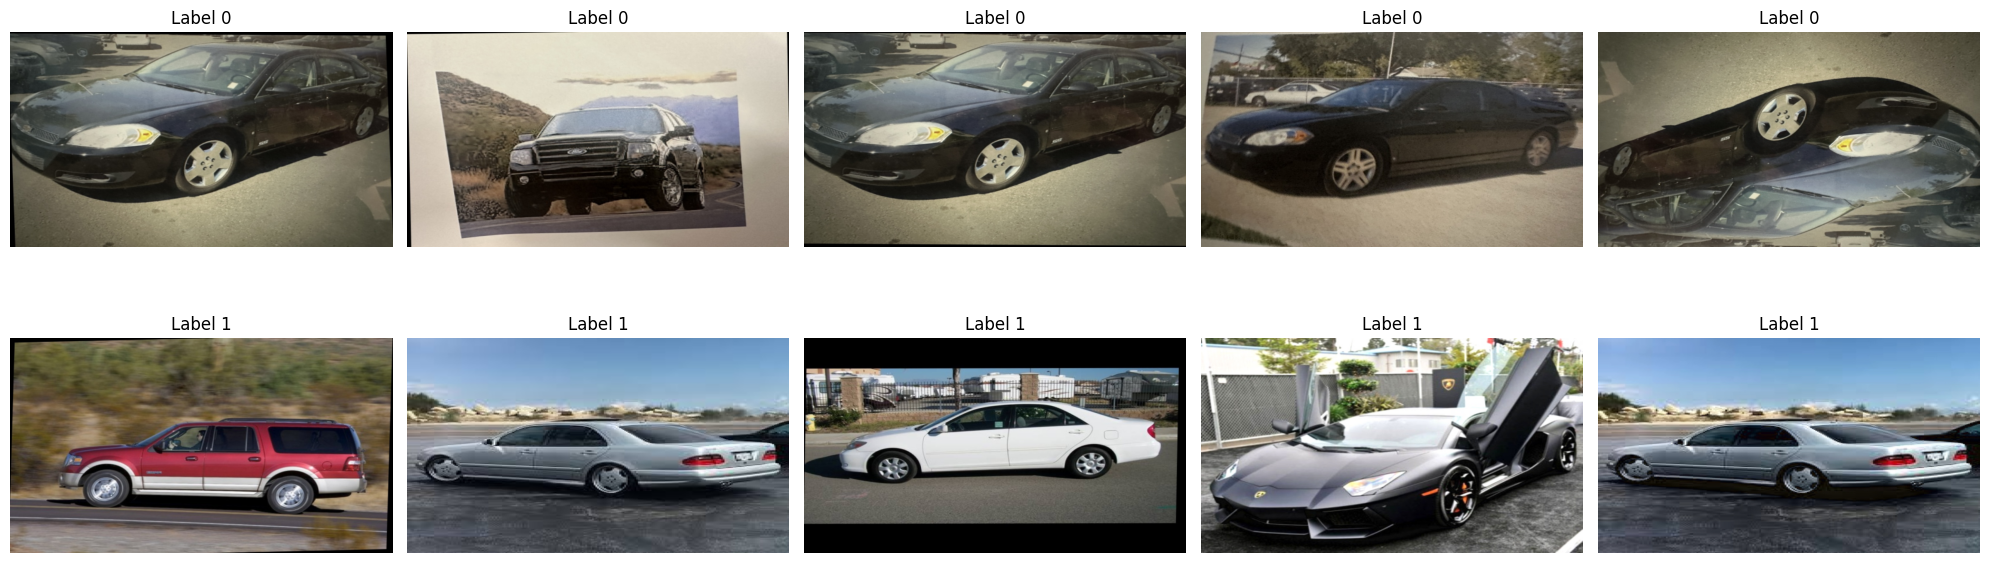

In [ ]:
import matplotlib.pyplot as plt

# find 5 images with label 0 and 5 with label 1
label_0_images = []
label_1_images = []

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label == 0 and len(label_0_images) < 5:
        label_0_images.append(image)
    elif label == 1 and len(label_1_images) < 5:
        label_1_images.append(image)
    if len(label_0_images) == 5 and len(label_1_images) == 5:
        break

# plot
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for row, image_list, lbl in zip([0, 1], [label_0_images, label_1_images], [0, 1]):
    for col, image in enumerate(image_list):
        img_np = image.numpy()
        if img_np.shape[0] in [1, 3]:  # (C, H, W)
            img_np = img_np.transpose(1, 2, 0)  # → (H, W, C)

        axes[row, col].imshow(img_np)
        axes[row, col].set_title(f"Label {lbl}")
        axes[row, col].axis('off')

        axes[row, col].set_aspect(img_np.shape[0] / img_np.shape[1])

plt.tight_layout()
plt.show()

In [ ]:
class IsCarRealModel(nn.Module):
    def __init__(self, pretrained=True):
        super(IsCarRealModel, self).__init__()
        self.resnet = models.resnet101(pretrained=pretrained)

        # replace avgpool for flexibility
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # custom FC head
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# instantiate model
model = IsCarRealModel(pretrained=True)
model = model.to(device)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 220MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.war

In [ ]:
import torch
print(torch.cuda.is_available())           # Should be True
print(torch.cuda.device_count())           # Should be ≥ 1
print(torch.cuda.get_device_name(0))       # Should return GPU name

True
1
NVIDIA A100-SXM4-40GB


In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(outputs)

            # Store predictions and targets
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    return epoch_loss, np.array(all_preds).flatten(), np.array(all_targets).flatten()

In [ ]:
# Number of epochs
num_epochs = 100
best_val_loss = float('inf')

# Lists to store metrics
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    model.train()
    train_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1).float()  # make sure targets shape is (batch_size, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass + optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average train loss
    epoch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    val_loss, val_preds, val_targets = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Update LR scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_car_real_model_resnet101.pth')
        print(f"Model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/638 [00:00<?, ?it/s]

/tmp/ipython-input-8-2999426559.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.0768, Val Loss: 0.1429
Model saved at epoch 1 with validation loss: 0.1429


Epoch 2/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 0.0253, Val Loss: 0.6906


Epoch 3/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 0.0245, Val Loss: 0.0256
Model saved at epoch 3 with validation loss: 0.0256


Epoch 4/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 0.0213, Val Loss: 0.0132
Model saved at epoch 4 with validation loss: 0.0132


Epoch 5/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 0.0115, Val Loss: 0.0208


Epoch 6/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 0.0114, Val Loss: 0.1083


Epoch 7/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 0.0106, Val Loss: 0.0110
Model saved at epoch 7 with validation loss: 0.0110


Epoch 8/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 0.0088, Val Loss: 0.0603


Epoch 9/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 0.0139, Val Loss: 0.0060
Model saved at epoch 9 with validation loss: 0.0060


Epoch 10/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0083, Val Loss: 0.0090


Epoch 11/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 0.0047, Val Loss: 0.0304


Epoch 12/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 0.0004, Val Loss: 0.0148


Epoch 13/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 0.0000, Val Loss: 0.0076


Epoch 14/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 0.0251, Val Loss: 0.1577


Epoch 15/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 0.0063, Val Loss: 0.0190


Epoch 16/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 0.0071, Val Loss: 0.0026
Model saved at epoch 16 with validation loss: 0.0026


Epoch 17/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 0.0022, Val Loss: 0.0061


Epoch 18/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 0.0002, Val Loss: 0.0051


Epoch 19/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 0.0147, Val Loss: 0.0110


Epoch 20/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.0051, Val Loss: 0.0124


Epoch 21/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 0.0022, Val Loss: 0.0222


Epoch 22/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 0.0003, Val Loss: 0.0028


Epoch 23/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 0.0004, Val Loss: 0.0024
Model saved at epoch 23 with validation loss: 0.0024


Epoch 24/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 0.0003, Val Loss: 0.0028


Epoch 25/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 0.0001, Val Loss: 0.0028


Epoch 26/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 0.0001, Val Loss: 0.0030


Epoch 27/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 0.0001, Val Loss: 0.0012
Model saved at epoch 27 with validation loss: 0.0012


Epoch 28/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 0.0000, Val Loss: 0.0038


Epoch 29/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 0.0001, Val Loss: 0.0062


Epoch 30/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 0.0019, Val Loss: 0.0062


Epoch 31/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 0.0002, Val Loss: 0.0031


Epoch 32/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 0.0000, Val Loss: 0.0019


Epoch 33/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 0.0000, Val Loss: 0.0038


Epoch 34/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 0.0000, Val Loss: 0.0058


Epoch 35/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 0.0002, Val Loss: 0.0045


Epoch 36/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 0.0001, Val Loss: 0.0037


Epoch 37/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 0.0000, Val Loss: 0.0003
Model saved at epoch 37 with validation loss: 0.0003


Epoch 38/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 0.0004, Val Loss: 0.0088


Epoch 39/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 0.0002, Val Loss: 0.0073


Epoch 40/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 0.0027, Val Loss: 0.0259


Epoch 41/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 0.0006, Val Loss: 0.0025


Epoch 42/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 0.0003, Val Loss: 0.0002
Model saved at epoch 42 with validation loss: 0.0002


Epoch 43/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 44/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 0.0012, Val Loss: 0.0089


Epoch 45/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 0.0007, Val Loss: 0.0010


Epoch 46/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 0.0003, Val Loss: 0.0040


Epoch 47/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 0.0000, Val Loss: 0.0054


Epoch 48/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 0.0000, Val Loss: 0.0036


Epoch 49/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 0.0000, Val Loss: 0.0093


Epoch 50/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 0.0016, Val Loss: 0.0190


Epoch 51/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 0.0003, Val Loss: 0.0018


Epoch 52/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 0.0001, Val Loss: 0.0014


Epoch 53/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 0.0000, Val Loss: 0.0047


Epoch 54/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 54/100, Train Loss: 0.0002, Val Loss: 0.0040


Epoch 55/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 55/100, Train Loss: 0.0000, Val Loss: 0.0048


Epoch 56/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 56/100, Train Loss: 0.0000, Val Loss: 0.0021


Epoch 57/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 57/100, Train Loss: 0.0000, Val Loss: 0.0094


Epoch 58/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 58/100, Train Loss: 0.0001, Val Loss: 0.0024


Epoch 59/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 59/100, Train Loss: 0.0000, Val Loss: 0.0052


Epoch 60/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 60/100, Train Loss: 0.0001, Val Loss: 0.0012


Epoch 61/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 61/100, Train Loss: 0.0031, Val Loss: 0.0085


Epoch 62/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 62/100, Train Loss: 0.0000, Val Loss: 0.0012


Epoch 63/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 63/100, Train Loss: 0.0000, Val Loss: 0.0025


Epoch 64/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 64/100, Train Loss: 0.0004, Val Loss: 0.0088


Epoch 65/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 65/100, Train Loss: 0.0007, Val Loss: 0.0015


Epoch 66/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 66/100, Train Loss: 0.0000, Val Loss: 0.0047


Epoch 67/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 67/100, Train Loss: 0.0000, Val Loss: 0.0006


Epoch 68/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 68/100, Train Loss: 0.0000, Val Loss: 0.0015


Epoch 69/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 69/100, Train Loss: 0.0000, Val Loss: 0.0026


Epoch 70/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 70/100, Train Loss: 0.0000, Val Loss: 0.0030


Epoch 71/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 71/100, Train Loss: 0.0000, Val Loss: 0.0008


Epoch 72/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 72/100, Train Loss: 0.0003, Val Loss: 0.0103


Epoch 73/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 73/100, Train Loss: 0.0000, Val Loss: 0.0008


Epoch 74/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 74/100, Train Loss: 0.0000, Val Loss: 0.0093


Epoch 75/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 75/100, Train Loss: 0.0000, Val Loss: 0.0055


Epoch 76/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 76/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 77/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 77/100, Train Loss: 0.0000, Val Loss: 0.0010


Epoch 78/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 78/100, Train Loss: 0.0000, Val Loss: 0.0010


Epoch 79/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 79/100, Train Loss: 0.0000, Val Loss: 0.0043


Epoch 80/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 80/100, Train Loss: 0.0000, Val Loss: 0.0030


Epoch 81/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 81/100, Train Loss: 0.0000, Val Loss: 0.0014


Epoch 82/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 82/100, Train Loss: 0.0000, Val Loss: 0.0024


Epoch 83/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 83/100, Train Loss: 0.0000, Val Loss: 0.0007


Epoch 84/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 84/100, Train Loss: 0.0000, Val Loss: 0.0009


Epoch 85/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 85/100, Train Loss: 0.0009, Val Loss: 0.0018


Epoch 86/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 86/100, Train Loss: 0.0004, Val Loss: 0.0007


Epoch 87/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 87/100, Train Loss: 0.0000, Val Loss: 0.0016


Epoch 88/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 88/100, Train Loss: 0.0000, Val Loss: 0.0031


Epoch 89/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 89/100, Train Loss: 0.0016, Val Loss: 0.0070


Epoch 90/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 90/100, Train Loss: 0.0000, Val Loss: 0.0028


Epoch 91/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 91/100, Train Loss: 0.0000, Val Loss: 0.0007


Epoch 92/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 92/100, Train Loss: 0.0000, Val Loss: 0.0020


Epoch 93/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 93/100, Train Loss: 0.0000, Val Loss: 0.0025


Epoch 94/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 94/100, Train Loss: 0.0000, Val Loss: 0.0058


Epoch 95/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 95/100, Train Loss: 0.0000, Val Loss: 0.0101


Epoch 96/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 96/100, Train Loss: 0.0000, Val Loss: 0.0011


Epoch 97/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 97/100, Train Loss: 0.0000, Val Loss: 0.0015


Epoch 98/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 98/100, Train Loss: 0.0004, Val Loss: 0.0034


Epoch 99/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 99/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 100/100:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

Epoch 100/100, Train Loss: 0.0000, Val Loss: 0.0017


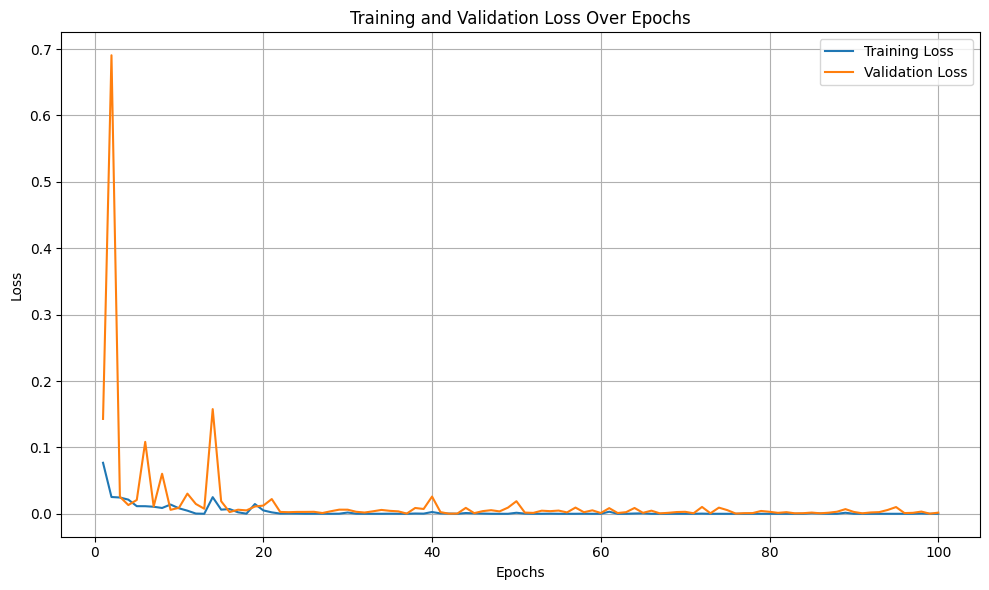

In [ ]:
import matplotlib.pyplot as plt

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation on test set

In [ ]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm

def evaluate_model_with_time(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_preds = []
    times = []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            elapsed_time = end_time - start_time
            time_per_sample = elapsed_time / inputs.size(0)
            times.append(time_per_sample * 1000)  # ms per sample

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)

    # Compute average and std dev of inference time
    avg_inference_time_ms = np.mean(times)
    std_inference_time_ms = np.std(times)

    return epoch_loss, np.array(all_preds).flatten(), np.array(all_targets).flatten(), avg_inference_time_ms, std_inference_time_ms


### GPU

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# load model
model.load_state_dict(torch.load('best_car_real_model_resnet101.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Compute Capability: {torch.cuda.get_device_capability(0)}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDNN Version: {torch.backends.cudnn.version()}")


# pass to evaluate_model_with_time
test_loss, test_preds, test_targets, avg_time, std_time = evaluate_model_with_time(model, test_loader, criterion, device)

# make probs > 0.5 = class 1
binary_preds = (test_preds >= 0.5).astype(int)

# compute metrics
acc = accuracy_score(test_targets, binary_preds)
precision = precision_score(test_targets, binary_preds,pos_label=0)
recall = recall_score(test_targets, binary_preds,pos_label=0)
f1 = f1_score(test_targets, binary_preds,pos_label=0)
specificity = recall_score(test_targets, binary_preds, pos_label=1)
cm = confusion_matrix(test_targets, binary_preds,labels=[0, 1])

# print results
print("\nTest Set Performance Metrics:")
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")
print(f"Inference Time:  {avg_time:.2f} ± {std_time:.2f} ms/sample")
print("\nConfusion Matrix:")
print(cm)

GPU: NVIDIA A100-SXM4-40GB
Compute Capability: (8, 0)
CUDA Version: 12.4
CUDNN Version: 90300


Evaluating:   0%|          | 0/2088 [00:00<?, ?it/s]

/tmp/ipython-input-684695176.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)



Test Set Performance Metrics:
Accuracy:    0.9871
Precision:   0.9971
Recall:      0.9770
Specificity: 0.9971
F1 Score:    0.9869
Inference Time:  14.55 ± 0.47 ms/sample

Confusion Matrix:
[[1020   24]
 [   3 1041]]


### CPU

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import platform
import psutil

# load model
model.load_state_dict(torch.load('best_car_real_model_resnet101.pth'))
device = torch.device("cpu")
model.to(device)
print(f"Using device: {device}")
print(f"Processor: {platform.processor()}")
print(f"Machine:   {platform.machine()}")
print(f"System:    {platform.system()} {platform.release()}")
print(f"CPU Cores: Physical={psutil.cpu_count(logical=False)}, Logical={psutil.cpu_count(logical=True)}")
# CPU frequency
cpu_freq = psutil.cpu_freq()
if cpu_freq:
    print(f"CPU Frequency: {cpu_freq.current:.2f} MHz (Base: {cpu_freq.min:.2f} MHz, Max: {cpu_freq.max:.2f} MHz)")


# pass to evaluate_model_with_time
test_loss, test_preds, test_targets, avg_time, std_time = evaluate_model_with_time(model, test_loader, criterion, device)

# make probs > 0.5 = class 1
binary_preds = (test_preds >= 0.5).astype(int)

# compute metrics
acc = accuracy_score(test_targets, binary_preds)
precision = precision_score(test_targets, binary_preds,pos_label=0)
recall = recall_score(test_targets, binary_preds,pos_label=0)
f1 = f1_score(test_targets, binary_preds,pos_label=0)
specificity = recall_score(test_targets, binary_preds, pos_label=1)
cm = confusion_matrix(test_targets, binary_preds,labels=[0, 1])

# print results
print("\nTest Set Performance Metrics:")
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")
print(f"Inference Time:  {avg_time:.2f} ± {std_time:.2f} ms/sample")
print("\nConfusion Matrix:")
print(cm)

Using device: cpu
Processor: x86_64
Machine:   x86_64
System:    Linux 6.1.123+
CPU Cores: Physical=6, Logical=12
CPU Frequency: 2200.20 MHz (Base: 0.00 MHz, Max: 0.00 MHz)


Evaluating:   0%|          | 0/2088 [00:00<?, ?it/s]

/tmp/ipython-input-684695176.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)



Test Set Performance Metrics:
Accuracy:    0.9871
Precision:   0.9971
Recall:      0.9770
Specificity: 0.9971
F1 Score:    0.9869
Inference Time:  265.62 ± 47.86 ms/sample

Confusion Matrix:
[[1020   24]
 [   3 1041]]
